# Train and test model to classify hand gestures
## Importing modules

In [1]:
import os.path
import numpy as np
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt

These are the standard python modules used here in this program.
* __os:__ To find certain directories and to generate file/directory full address
* __numpy:__ To handle numpy arrays
* __collections:__ To use the Counter class to show the number of each gestures used for training and testing the model
* __matplotlib:__ To plot the graph of the acceleration data

In [2]:
import keras
from keras.models import Model
from keras.layers import Dense, Input, LSTM
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


Here we import keras module and other required classes from it that are required to build our Artificial Neural Network and to plot confusion matrix.

In [3]:
import sys
sys.path.insert(0, "src")
from Utils import load_processed_data, LABELS

__Utils__ module contains some custom functions and is located in the __src__ directory of our project. By adding __src__ in the system path, we can import the modules from it directly.
Description of the functions loaded from __Utils__ modules are as follows:
* __load_processed_data:__ Loads a processed data from a given csv file where each row contains the x-, y-, and z-acceleration data stacked one after another and followed by its label. The values are normalized in the range 0-1 inclusively and smoothed using a moving average window.

__LABELS__ is a tuple with labels of the gestures.

## Local functions
-  __execute_layers:__ This function takes a list of inputs and layers as arguments and passes each input through all the layers and returns a list of outputs from each input.

In [4]:
def execute_layers(inputs, layers):
    """
    Computes each input to all given layers and return their outputs
    @param inputs : List of inputs to be passed through the given layer(s)
    @param layers : List of layers though which each input will be passed
    @return       : List of output generated from each input
    """
    outputs = []
    for _input in inputs:
        _output = _input
        for layer in layers:
            _output = layer(_output)
        outputs.append(_output)
    return outputs

## Loading train and test data
Number of sample points of the gestures are not same. Therefore, we need to pad them to achieve a given constant length for all gestures. __max_review_length__ denotes the maximum length of the sample points after padding them either at __"start"__ with initial value or at __"end"__ with final value.

In [17]:
max_review_length = 150
data_train, labels_train, data_test, labels_test = load_processed_data("Processed Data 12.06.2019 00.05.csv", 
                                                                       review_length=max_review_length, 
                                                                       pad_pos="start",
                                                                       train_ratio=0.1)
#data_train, labels_train = load_processed_data("Train Processed Data 22.05.2019 14.16.csv", review_length=max_review_length, pad_pos="start")
#data_test , labels_test  = load_processed_data("Test Processed Data 22.05.2019 14.17.csv",  review_length=max_review_length, pad_pos="start")

## Plotting accelerations
Here we plot one graph for each gesture. The graph shows the x-, y- and z-acceleration readings of BBC Microbit against time.

__Acceleration values are normalized within the range 0-1 inclusively.__

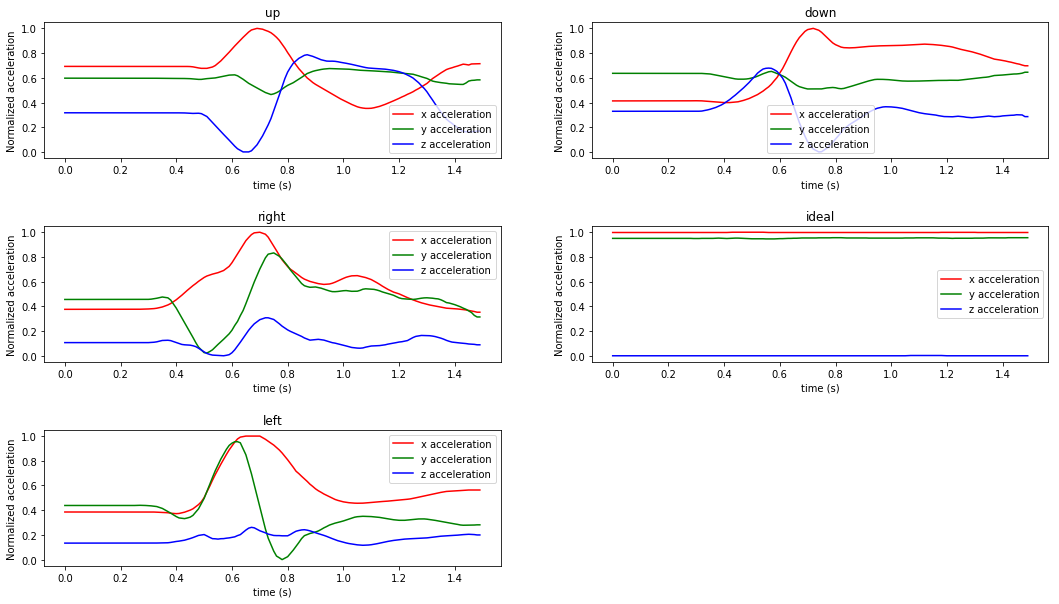

In [18]:
NUM_LABELS = len(LABELS)
sample_period = 0.01
start_index = 0                                           # Initial index
last_index  = len(data_train[0])-1                        # Final index = Length of data-1
figures = []
# Matplot plot formatting
plt.figure(figsize=(18.0, 10.0))                          # Setting plot figure size
plt.subplots_adjust(hspace=0.5)                           # Adjusting hrizontal spacing between subplots0
t = np.arange(max_review_length)*sample_period            # Time range for each plot
for i in range(NUM_LABELS):
    # Select offset of unique data
    for index in range(start_index, last_index):          # Offset = (start_index, last_index)
        label_index = labels_train[index+i].argmax()
        if label_index not in figures:                    # Given gesture type not plotted?
            figures.append(label_index)
            start_index = index+1                         # Start loop next time from next index 
            break
    else:
        print("✘ Not enough data: Only {} different plots drawn.".format(i))
        break
    plt.subplot(3, 2, i+1)
    plt.title(LABELS[label_index])
    plt.xlabel("time (s)")
    plt.ylabel("Normalized acceleration")
    x, y, z = data_train[:, index+i, 0]
    plt.plot(t, x, "r", label="x acceleration")
    plt.plot(t, y, "g", label="y acceleration")
    plt.plot(t, z, "b", label="z acceleration")
    plt.legend()

## Layers and Model initialisation

Here we initialise our inputs i.e acceleration readings in x, y and z planes. 

In [19]:
input_x = Input(shape=(1, max_review_length), name="Acceleration_x")
input_y = Input(shape=(1, max_review_length), name="Acceleration_y")
input_z = Input(shape=(1, max_review_length), name="Acceleration_z")

For our neural network, we have intialized LSTM with dropout and Dense layers. **tanh** activation function in LSTM layer and **ReLu** activation functions in Dense layers seems to produce better result.

In [20]:
shared_layers = (LSTM(max_review_length, activation="tanh", name="Shared_LSTM", dropout=0.75),
                 Dense(NUM_LABELS*3*64,  activation="relu", name="Shared_Dense_1"),
                 Dense(NUM_LABELS*3*64,  activation="relu", name="Shared_Dense_2"),
                 Dense(NUM_LABELS*1*64,  activation="relu", name="Shared_Dense_3"))
"""shared_layers = (LSTM(20, activation="tanh", name="Shared_LSTM", dropout=0.75),
                 Dense(25,  activation="relu", name="Shared_Dense_1"),
                 Dense(45,  activation="relu", name="Shared_Dense_2"))"""

'shared_layers = (LSTM(20, activation="tanh", name="Shared_LSTM", dropout=0.75),\n                 Dense(25,  activation="relu", name="Shared_Dense_1"),\n                 Dense(45,  activation="relu", name="Shared_Dense_2"))'

The LSTM and dense layers are shared by each input; for a single gesture, we train the each layer with the x, y and z input acceleration inputs.
The **execute_layers()** function passes each input through all these layers and returns an array with output from each input.

In [21]:
shared_output = execute_layers(inputs=(input_x, input_y, input_z), layers=shared_layers)

The outputs of the inputs (x, y and z) are concatenated and passed further through Dense layers where the final Dense layer is our softmax classification layer. 

In [22]:
concat      = keras.layers.concatenate(shared_output,name="Concatenate")
dense_1     = Dense(39, activation="relu",    name="Dense_1")(concat)
main_output = Dense(NUM_LABELS,   activation="softmax", name="Classification_Layer")(dense_1)

## Creating, training and testing model
The model with above inputs and outputs is created. It is then trained using the processed training data and tested with the processed testing data.

In [23]:
model = Model(inputs=(input_x, input_y, input_z), outputs=main_output)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
print("Model Summary", model.summary(), sep="\n")
history = model.fit(x=[*data_train], y=labels_train, epochs=10, batch_size=10)

print("\nTesting")
scores = model.evaluate(x=[*data_test], y=labels_test, batch_size=10, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Acceleration_x (InputLayer)     (None, 1, 150)       0                                            
__________________________________________________________________________________________________
Acceleration_y (InputLayer)     (None, 1, 150)       0                                            
__________________________________________________________________________________________________
Acceleration_z (InputLayer)     (None, 1, 150)       0                                            
__________________________________________________________________________________________________
Shared_LSTM (LSTM)              (None, 150)          180600      Acceleration_x[0][0]             
                                                                 Acceleration_y[0][0]             
          

## Accuracy and loss values graph
Below we can see the graph of **accuracy** and **loss** values of the model against **epoch** while training.

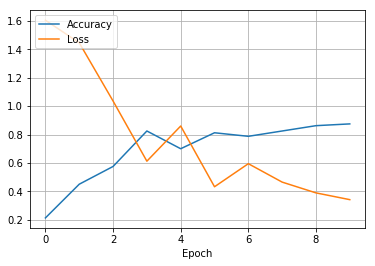

In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

## Confusion Matrix
Using confusion matrix, we can observe the performance of our model while testing it with our test data.

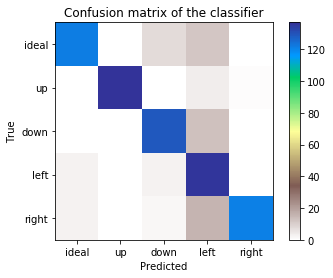

In [25]:
labels = ["ideal", "up", "down", "left", "right"]
y_pred = [labels[i] for i in np.argmax(model.predict([*data_test]), axis=1)]
y_test = y_true = [labels[i] for i in np.argmax(labels_test, axis=1)]
y_train = [labels[i] for i in np.argmax(labels_train, axis=1)]
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.terrain_r)
plt.title('Confusion matrix of the classifier')
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()

The values of the confusion martix are as follows:

In [26]:
print("Confusion Matrix:", "\n".join(map(str, cm)), sep="\n\n")

Confusion Matrix:

[122   0   8  12   0]
[  0 137   0   4   1]
[  0   0 129  13   0]
[  3   0   3 136   0]
[  3   0   2  16 121]


Below we can see the number of data we used from each gesture to train and test the model.

In [27]:
print("Train data:", Counter(y_train))
print("Test  data:", Counter(y_test))

Train data: Counter({'up': 16, 'ideal': 16, 'down': 16, 'right': 16, 'left': 16})
Test  data: Counter({'right': 142, 'down': 142, 'up': 142, 'left': 142, 'ideal': 142})


## Saving trained model
Once our model is trained and tested, we need to save the trained model. The model is saved if the accuracy of the model is atleast the accuracy threshold value. 

The model name indicates the date and time when the model was saved and the model can be found in the **Models** directory.

In [28]:
accuracy_threshold = 0.96
if scores[1] >= accuracy_threshold:
    model_file = "Model {accuracy:.2f} {date}.HDF5".format(
        date=datetime.now().strftime("%d.%m.%Y %H.%M"), accuracy=(scores[1]*100))
    if not os.path.exists("Models"):
        os.makedirs("Models")
    file_path = os.path.join("Models", model_file)
    model.save(file_path)
    print("✓ Model saved: {}".format(file_path))
else:
    print("✘ Model not saved!")

✘ Model not saved!
